In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install pexels-api
!git clone https://github.com/AguilarLagunasArturo/pexels-image-downloader.git

In [ ]:
# Pexels API Key: 563492ad6f91700001000001ad9e8a1f0ced441e9be0fe14f7092778

In [ ]:
# !python /content/pexels-image-downloader/download.py -m mountains 10 /content/simple/

In [ ]:
!unzip /content/drive/MyDrive/Btech_project/Datasets/dataset_1.zip

Streaming output truncated to the last 5000 lines.
  inflating: dataset_1/train/00000286_(4).jpg  
  inflating: dataset_1/train/00000286_(5).jpg  
  inflating: dataset_1/train/00000286_(6).jpg  
  inflating: dataset_1/train/00000287.jpg  
  inflating: dataset_1/train/00000287_(2).jpg  
  inflating: dataset_1/train/00000287_(4).jpg  
  inflating: dataset_1/train/00000287_(6).jpg  
  inflating: dataset_1/train/00000288.jpg  
  inflating: dataset_1/train/00000288_(2).jpg  
  inflating: dataset_1/train/00000288_(3).jpg  
  inflating: dataset_1/train/00000288_(4).jpg  
  inflating: dataset_1/train/00000288_(5).jpg  
  inflating: dataset_1/train/00000288_(6).jpg  
  inflating: dataset_1/train/00000289.jpg  
  inflating: dataset_1/train/00000289_(2).jpg  
  inflating: dataset_1/train/00000289_(3).jpg  
  inflating: dataset_1/train/00000289_(4).jpg  
  inflating: dataset_1/train/00000289_(5).jpg  
  inflating: dataset_1/train/00000289_(6).jpg  
  inflating: dataset_1/train/00000290.jpg  
  inf

In [ ]:
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, UpSampling2D, Input,Reshape, concatenate
from tensorflow.keras.layers import Activation, Dense, Dropout, Flatten, InputLayer
from tensorflow.keras.layers import BatchNormalization, RepeatVector
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.applications.inception_resnet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import skimage
from skimage.color import rgb2lab, lab2rgb, rgb2gray, gray2rgb
from skimage.io import imsave
from skimage.transform import resize
import numpy as np
import os
import random
import tensorflow as tf
import matplotlib.pyplot as plt
import gc
from warnings import filterwarnings
filterwarnings("ignore")

In [ ]:
# Get images
X = []
for filename in os.listdir('/content/sunset'):
    X.append(img_to_array(load_img('/content/sunset/'+filename,target_size=(256,256))))
X = np.array(X, dtype=float)

# Set up train and test data
split = int(0.95*len(X))
Xtrain = X[:split]
Xtrain = 1.0/255*Xtrain

In [ ]:
Xtrain.shape

(798, 256, 256, 3)

## Baseline CNN

#### Our Baseline model

In [ ]:
## BASELINE ARCH
model = Sequential()
model.add(InputLayer(input_shape=(256, 256, 1)))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', strides=2))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same', strides=2))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(2, (3, 3), activation='tanh', padding='same'))
model.compile(optimizer=tf.keras.optimizers.Adam(0.001), loss='mse',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_217 (Conv2D)          (None, 256, 256, 32)      320       
_________________________________________________________________
conv2d_218 (Conv2D)          (None, 128, 128, 32)      9248      
_________________________________________________________________
conv2d_219 (Conv2D)          (None, 128, 128, 64)      18496     
_________________________________________________________________
conv2d_220 (Conv2D)          (None, 64, 64, 64)        36928     
_________________________________________________________________
conv2d_221 (Conv2D)          (None, 64, 64, 128)       73856     
_________________________________________________________________
up_sampling2d_3 (UpSampling2 (None, 128, 128, 128)     0         
_________________________________________________________________
conv2d_222 (Conv2D)          (None, 128, 128, 64)      7

In [ ]:
class ImageGenerator(tf.keras.utils.Sequence):
    def __init__(self, img_dir, img_size=(256,256),batch_size=16,shuffle=True):
        self.batch_size = batch_size
        self.img_dir = img_dir
        self.img_size = img_size
        self.img_list = os.listdir(self.img_dir)
        self.n = len(self.img_list)
        self.shuffle = shuffle
        self.on_epoch_end() 

    def __len__(self):
        '''Denotes the number of batches per epoch'''
        return int(np.ceil(self.n/self.batch_size))

    def __getitem__(self,index):
        indices = self.indices[index*self.batch_size:(index+1)*self.batch_size]

        batch_filenames = [self.img_list[i] for i in indices]

        X, y = self.__get_data(batch_filenames)
        
        return X, y

    def __get_data(self, batch_filenames):
        imgs = []
        for i, fname in enumerate(batch_filenames):
            img = img_to_array(load_img(self.img_dir + fname,target_size=self.img_size))
            imgs.append(img)
        
        imgs = np.array(imgs)
        #apply on batch
        img_lab = rgb2lab(imgs/255.0)
        img_l = np.expand_dims(img_lab[:,:,:,0],-1) #(h,w,1)
        img_ab = img_lab[:,:,:,1:]/128    
        del imgs          

        return np.array(img_l),np.array(img_ab)

    def on_epoch_end(self):
        self.indices = np.arange(self.n)
        if self.shuffle:
            np.random.shuffle(self.indices)

In [ ]:
datagen = ImageGenerator('/content/jungle/',batch_size=32,img_size=(256,256))

 #### Use this only if training set is in memory numpy array

In [ ]:
# Image transformer
# datagen = ImageDataGenerator(
        # shear_range=0.2,
        # zoom_range=0.2,
        # rotation_range=20,
        # horizontal_flip=True)

# Generate training data
# batch_size = 16
# def image_a_b_gen(batch_size):
#     for batch in datagen.flow(Xtrain, batch_size=batch_size):
#         lab_batch = rgb2lab(batch)
#         X_batch = lab_batch[:,:,:,0]
#         Y_batch = lab_batch[:,:,:,1:] / 128
#         yield (X_batch.reshape(X_batch.shape+(1,)), Y_batch)


#### Training CNN(Autoencoder type) from scratch model


In [ ]:
# Train model      
# tensorboard = TensorBoard(log_dir="output/first_run")
# trained_model = model.fit(image_a_b_gen(batch_size), epochs=100,steps_per_epoch=len(Xtrain)//batch_size)  #, callbacks=[tensorboard]

hist = model.fit(datagen, epochs=100)

Epoch 1/100
125/125 [==============================] - 126s 1s/step - loss: 0.0876 - accuracy: 0.5671
Epoch 2/100
125/125 [==============================] - 126s 1s/step - loss: 0.0163 - accuracy: 0.6238
Epoch 3/100
125/125 [==============================] - 126s 1s/step - loss: 0.0151 - accuracy: 0.6524
Epoch 4/100
125/125 [==============================] - 126s 1s/step - loss: 0.0147 - accuracy: 0.6566
Epoch 5/100
125/125 [==============================] - 126s 1s/step - loss: 0.0144 - accuracy: 0.6612
Epoch 6/100
125/125 [==============================] - 126s 1s/step - loss: 0.0143 - accuracy: 0.6606
Epoch 7/100
125/125 [==============================] - 127s 1s/step - loss: 0.0143 - accuracy: 0.6611
Epoch 8/100
125/125 [==============================] - 126s 1s/step - loss: 0.0141 - accuracy: 0.6656
Epoch 9/100
125/125 [==============================] - 126s 1s/step - loss: 0.0141 - accuracy: 0.6630
Epoch 10/100
125/125 [==============================] - 127s 1s/step - loss: 0.013

In [ ]:
# summarize history for accuracy
plt.plot(trained_model.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(trained_model.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
!nvidia-smi

In [ ]:
# del model

In [ ]:
gc.collect()

In [ ]:
# Save model
model.save("/content/drive/MyDrive/Btech_project/saved_models/simple_100ep_landscapes.h5")
# model.save("/content/simple_rmsprop_500ep.h5")

In [ ]:
model = tf.keras.models.load_model("/content/drive/MyDrive/Btech_project/saved_models/simple_100ep_mae_1.h5")

In [ ]:
model2 = tf.keras.models.load_model("/content/drive/MyDrive/Btech_project/saved_models/simple_100ep_1.h5")

In [ ]:
def to_rgb(gray, ab):
    '''rgb image from grayscale and ab channels'''
    ab = ab*128
    lab_img = np.concatenate((gray,ab),axis=2)
    rgb_img = lab2rgb(lab_img)
    # rgb_img = (rgb_img*255).astype('uint8')
    return rgb_img

In [ ]:
sample = datagen[0] #next(image_a_b_gen(10))
sample[0].shape

(32, 256, 256, 1)

In [ ]:
# sample = next(image_a_b_gen(10))
prediction = model.predict(sample[0])
prediction *= 128
op = np.zeros((32,256, 256, 3))
op[:,:,:,0] = sample[0][:,:,:,0]
op[:,:,:,1:] = prediction

prediction2 = model2.predict(sample[0])
prediction2 *= 128
op2 = np.zeros((32,256, 256, 3))
op2[:,:,:,0] = sample[0][:,:,:,0]
op2[:,:,:,1:] = prediction2


Text(0.5, 1.0, 'Predicted2')

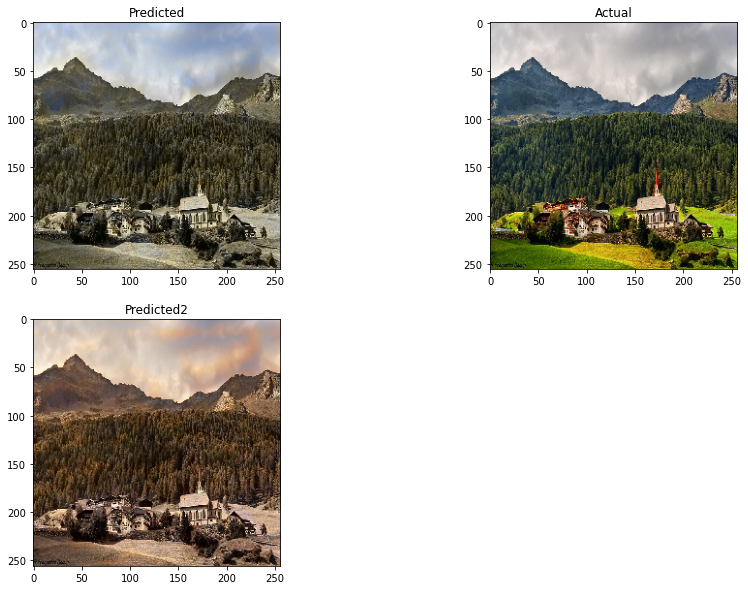

In [ ]:
i=10
original = to_rgb(sample[0][i], sample[1][i])

plt.figure(figsize=(15,10))
plt.subplot(221)
plt.imshow(lab2rgb(op[i])) #*255).astype('uint8')
plt.title('Predicted')
plt.subplot(222)
plt.imshow(original)
plt.title('Actual')
plt.subplot(223)
plt.imshow(lab2rgb(op2[i])) #*255).astype('uint8')
plt.title('Predicted2')

#### Testing

In [ ]:
# Test images

test_images = []
# for filename in os.listdir('/content/dataset_1/test/'):
#     test_images.append(img_to_array(load_img('/content/dataset_1/test/'+filename,target_size=(256,256))))
test_images = img_to_array(load_img('/content/jungle/0002.jpg',target_size=(256,256)))
test_images = np.array(test_images, dtype=float)
print(test_images.shape)
Xtest = rgb2lab(1.0/255*test_images)
Xtest = Xtest.reshape(Xtest.shape+(1,))
Ytest = rgb2lab(1.0/255*test_images)
Ytest = Ytest / 128

outputs = model.predict(Xtest)

predicted = []
actual = []
for i in range(len(Xtest)):
    predicted.append(to_rgb(Xtest[i],outputs[i]))
    actual.append(to_rgb(Xtest[i],Ytest[i]))

Text(0.5, 1.0, 'Actual')

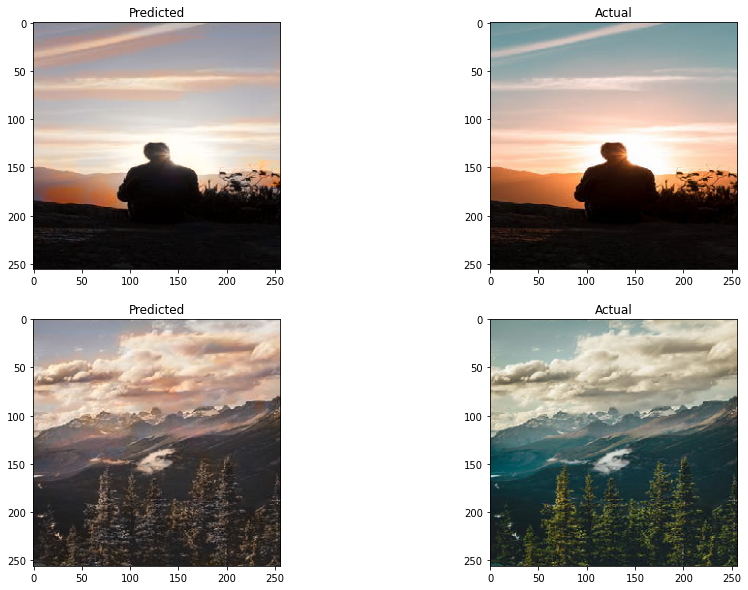

In [ ]:
plt.figure(figsize=(15,10))
plt.subplot(221)
plt.imshow(predicted[1])
plt.title('Predicted')
plt.subplot(222)
plt.imshow(actual[1])
plt.title('Actual')
plt.subplot(223)
plt.imshow(predicted[2])
plt.title('Predicted')
plt.subplot(224)
plt.imshow(actual[2])
plt.title('Actual')

## Inception-resnetv2 based 



In [ ]:
#Load weights
inception = InceptionResNetV2(weights=None, include_top=True)
inception.load_weights('/content/drive/MyDrive/Btech_project/saved_models/inception_resnet_v2_weights_tf_dim_ordering_tf_kernels.h5')
# inception.graph = tf.get_default_graph()

embed_input = Input(shape=(1000,))

#Encoder
encoder_input = Input(shape=(256, 256, 1,))
encoder_output = Conv2D(64, (3,3), activation='relu', padding='same', strides=2)(encoder_input)
encoder_output = Conv2D(128, (3,3), activation='relu', padding='same')(encoder_output)
encoder_output = Conv2D(128, (3,3), activation='relu', padding='same', strides=2)(encoder_output)
encoder_output = Conv2D(256, (3,3), activation='relu', padding='same')(encoder_output)
encoder_output = Conv2D(256, (3,3), activation='relu', padding='same', strides=2)(encoder_output)
encoder_output = Conv2D(512, (3,3), activation='relu', padding='same')(encoder_output)
encoder_output = Conv2D(512, (3,3), activation='relu', padding='same')(encoder_output)
encoder_output = Conv2D(256, (3,3), activation='relu', padding='same')(encoder_output)

#Fusion
fusion_output = RepeatVector(32 * 32)(embed_input) 
fusion_output = Reshape(([32, 32, 1000]))(fusion_output)
fusion_output = concatenate([encoder_output, fusion_output], axis=3) 
fusion_output = Conv2D(256, (1, 1), activation='relu', padding='same')(fusion_output) 

#Decoder
decoder_output = Conv2D(128, (3,3), activation='relu', padding='same')(fusion_output)
decoder_output = UpSampling2D((2, 2))(decoder_output)
decoder_output = Conv2D(64, (3,3), activation='relu', padding='same')(decoder_output)
decoder_output = UpSampling2D((2, 2))(decoder_output)
decoder_output = Conv2D(32, (3,3), activation='relu', padding='same')(decoder_output)
decoder_output = Conv2D(16, (3,3), activation='relu', padding='same')(decoder_output)
decoder_output = Conv2D(2, (3, 3), activation='tanh', padding='same')(decoder_output)
decoder_output = UpSampling2D((2, 2))(decoder_output)

model = Model(inputs=[encoder_input, embed_input], outputs=decoder_output)

#Create embedding
def create_inception_embedding(grayscaled_rgb):
    grayscaled_rgb_resized = []
    for i in grayscaled_rgb:
        i = resize(i, (299, 299, 3), mode='constant')
        grayscaled_rgb_resized.append(i)
    grayscaled_rgb_resized = np.array(grayscaled_rgb_resized)
    grayscaled_rgb_resized = preprocess_input(grayscaled_rgb_resized)
    embed = inception.predict(grayscaled_rgb_resized)
    return embed


In [ ]:
class InceptionImageGenerator(tf.keras.utils.Sequence):
    def __init__(self, img_dir, img_size=(256,256),batch_size=16,shuffle=True):
        self.batch_size = batch_size
        self.img_dir = img_dir
        self.img_size = img_size
        self.img_list = os.listdir(self.img_dir)
        self.n = len(self.img_list)
        self.shuffle = shuffle
        self.on_epoch_end() 

    def __len__(self):
        '''Denotes the number of batches per epoch'''
        return int(np.ceil(self.n/self.batch_size))

    def __getitem__(self,index):
        indices = self.indices[index*self.batch_size:(index+1)*self.batch_size]

        batch_filenames = [self.img_list[i] for i in indices]

        X, embed, y = self.__get_data(batch_filenames)
        
        return ([X, embed], y)

    def __get_data(self, batch_filenames):
        
        imgs = []
        for i, fname in enumerate(batch_filenames):
            img = img_to_array(load_img(self.img_dir + fname,target_size=self.img_size))
            imgs.append(img)
        imgs = np.array(imgs)
        #apply on batch
        grayscaled_rgb = gray2rgb(rgb2gray(imgs))
        embed = self.create_inception_embedding(grayscaled_rgb)

        img_lab = rgb2lab(imgs/255.0)
        img_l = np.expand_dims(img_lab[:,:,:,0],-1) #(h,w,1)
        img_ab = img_lab[:,:,:,1:]/128    
        del imgs          
        
        return np.array(img_l),np.array(embed),np.array(img_ab)

    def on_epoch_end(self):
        self.indices = np.arange(self.n)
        if self.shuffle:
            np.random.shuffle(self.indices)
    # applied on each batch
    def create_inception_embedding(self, grayscaled_rgb):

        grayscaled_rgb_resized = []
        for i in grayscaled_rgb:
            i = resize(i, (299, 299, 3), mode='constant')
            grayscaled_rgb_resized.append(i)
        grayscaled_rgb_resized = np.array(grayscaled_rgb_resized)
        grayscaled_rgb_resized = preprocess_input(grayscaled_rgb_resized)
        embed = inception.predict(grayscaled_rgb_resized)

        return embed

In [ ]:
!unzip /content/drive/MyDrive/Btech_project/Datasets/jungle.zip

In [ ]:
incep_train_datagen = InceptionImageGenerator('/content/dataset_1/train/',batch_size=32,img_size=(256,256))

(32, 256, 256, 1)

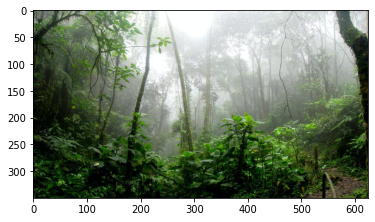

In [ ]:
sample = incep_train_datagen[0]
#plt.imshow(plt.imread('/content/jungle/0001.jpg'))
sample[0][0].shape

In [ ]:
sample[0][1].shape

(32, 1000)

 #### Use this only if training set is in memory numpy array

In [1]:
# # Image transformer
# datagen = ImageDataGenerator(
#         # shear_range=0.4,
#         # zoom_range=0.4,
#         # rotation_range=40,
#         horizontal_flip=True)
# batch_size = 16
# # for inception_resnet fusion
# def image_a_b_gen(batch_size):
#     for batch in datagen.flow(Xtrain, batch_size=batch_size):
#         grayscaled_rgb = gray2rgb(rgb2gray(batch))
#         embed = create_inception_embedding(grayscaled_rgb)
#         lab_batch = rgb2lab(batch)
#         X_batch = lab_batch[:,:,:,0]
#         X_batch = X_batch.reshape(X_batch.shape+(1,))
#         Y_batch = lab_batch[:,:,:,1:] / 128
#         yield ([X_batch, embed], Y_batch)

#### Training Inception-resnetv2 based model


In [ ]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d_203 (Conv2D)             (None, 128, 128, 64) 640         input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_204 (Conv2D)             (None, 128, 128, 128 73856       conv2d_203[0][0]                 
__________________________________________________________________________________________________
conv2d_205 (Conv2D)             (None, 64, 64, 128)  147584      conv2d_204[0][0]                 
_______________________________________________________________________________________

In [ ]:
model.load_weights("/content/drive/MyDrive/Btech_project/saved_models/dataset_1/incep_mse_finetune_20-0.00.h5")

In [ ]:
#Train model      
tensorboard = TensorBoard(log_dir="/content/drive/MyDrive/Btech_project/saved_models/output/incep")
checkpoint_filepath = '/content/drive/MyDrive/Btech_project/saved_models/dataset_1/'
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath+'incep_mse_finetune_{epoch:02d}-{loss:.2f}.h5',
    monitor='loss',
    save_freq=203*5)
model.compile(optimizer=tf.keras.optimizers.Adam(0.0001), loss='mse',metrics=['accuracy'])
hist = model.fit(incep_train_datagen, callbacks=[model_checkpoint,tensorboard],epochs=50) 

Epoch 1/50
  1/203 [..............................] - ETA: 0s - loss: 0.0028 - accuracy: 0.8792WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
203/203 [==============================] - 340s 2s/step - loss: 0.0029 - accuracy: 0.8605
Epoch 2/50
203/203 [==============================] - 336s 2s/step - loss: 0.0027 - accuracy: 0.8637
Epoch 3/50
203/203 [==============================] - 335s 2s/step - loss: 0.0027 - accuracy: 0.8653
Epoch 4/50
203/203 [==============================] - 334s 2s/step - loss: 0.0026 - accuracy: 0.8666
Epoch 5/50
203/203 [==============================] - 334s 2s/step - loss: 0.0026 - accuracy: 0.8678
Epoch 6/50
203/203 [==============================] - 331s 2s/step - loss: 0.0025 - accuracy: 0.8686
Epoch 7/50
203/203 [============

In [ ]:
# summarize history for accuracy
plt.plot(hist.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()

# summarize history for loss
plt.plot(hist.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
# Save model
model.save("/content/drive/MyDrive/Btech_project/saved_models/incep_ds1_100ep.h5")

saved models:

1. simple_100ep_1.h5: baseline arch + mse loss + Adam(0.001) for 100 epochs

2. simple_100ep_mae_1.h5: baseline arch + mae loss + Adam(0.001) for 100 epochs

3. simple_1000ep2_1.h5: baseline arch + mae loss + Adam(0.001) for 1000 epochs

full_ver_1.h5: inception_resnetv2 fusion + mse loss + Adam(0.001) for 100 epochs

full_ver_1_finetune.h5: inception_resnetv2 fusion + mse loss + Adam(0.0001) for 30 epochs

incep_ds1_100ep.h5: inception_resnetv2 fusion + mse loss + Adam(0.001) for 100 epochs on dataset_1




In [ ]:
model.load_weights("/content/drive/MyDrive/Btech_project/saved_models/dataset_1/incep_mse_65-0.00.h5")

In [ ]:
def to_rgb(gray, ab):
    '''rgb image from grayscale and ab channels'''
    ab = ab*128
    lab_img = np.concatenate((gray,ab),axis=2)
    rgb_img = lab2rgb(lab_img)
    # rgb_img = (rgb_img*255).astype('uint8')
    return rgb_img

In [ ]:
sample = incep_train_datagen[0]      #next(image_a_b_gen(10))
#print(.shape)
prediction = model.predict([sample[0][0],sample[0][1]])
prediction *= 128
op = np.zeros((32,256, 256, 3))
op[:,:,:,0] = sample[0][0][:,:,:,0]
op[:,:,:,1:] = prediction


In [ ]:
original = to_rgb(sample[0][0][4], sample[1][4])

plt.figure(figsize=(15,10))
plt.subplot(221)
plt.imshow(lab2rgb(op[4]))
plt.title('Predicted')
plt.subplot(222)
plt.imshow(original)
plt.title('Actual')

#### Testing

In [ ]:
# Test images
test_images = []
for filename in os.listdir('/content/dataset_1/test/'):
    test_images.append(img_to_array(load_img('/content/dataset_1/test/'+filename,target_size=(256,256))))
test_images = np.array(test_images, dtype=float)
Xtest = rgb2lab(1.0/255*test_images)[:,:,:,0]
Xtest = Xtest.reshape(Xtest.shape+(1,))
Ytest = rgb2lab(1.0/255*test_images)[:,:,:,1:]
Ytest = Ytest / 128
Xtest_embed = 1.0/255*test_images
Xtest_embed = gray2rgb(rgb2gray(Xtest_embed))
Xtest_embed = create_inception_embedding(Xtest_embed)

# print(model.evaluate(Xtest, Ytest, batch_size=batch_size))
outputs = model.predict([Xtest,Xtest_embed])

predicted = []
actual = []
for i in range(len(Xtest)):
    predicted.append(to_rgb(Xtest[i],outputs[i]))
    actual.append(to_rgb(Xtest[i],Ytest[i]))

In [ ]:
# Plot actual and predicted test images
fig, ax = plt.subplots(20, 2, figsize=(16,100))
row = 0
for img in test_images[60:80]:
    ax[row,0].imshow(img/255.0)
    row +=1

row = 0
for img in predicted[60:80]:
	ax[row,1].imshow(img)
	row +=1

plt.savefig('incep_mse_65ep_finetune_3.pdf')

Output hidden; open in https://colab.research.google.com to view.

## Comparing baseline CNN and Inception-resnetv2 based models

In [ ]:
model_beta = tf.keras.models.load_model('/content/drive/MyDrive/Btech_project/saved_models/dataset_1/baseline_mse_finetune_50-0.010.h5')
model_incep = tf.keras.models.load_model('/content/drive/MyDrive/Btech_project/saved_models/dataset_1/incep_mse_finetune_20-0.00.h5')

In [ ]:
!unzip '/content/sem7_test.zip'

In [ ]:
test_images = []
for filename in os.listdir('/content/dataset_1/test/'):
    test_images.append(img_to_array(load_img('/content/dataset_1/test/'+filename,target_size=(256,256))))
test_images = np.array(test_images, dtype=float)
Xtest = rgb2lab(1.0/255*test_images)[:,:,:,0]
Xtest = Xtest.reshape(Xtest.shape+(1,))
Ytest = rgb2lab(1.0/255*test_images)[:,:,:,1:]
Ytest = Ytest / 128
Xtest_embed = 1.0/255*test_images
Xtest_embed = gray2rgb(rgb2gray(Xtest_embed))
Xtest_embed = create_inception_embedding(Xtest_embed)

print(model_beta.evaluate(Xtest, Ytest, batch_size=32))
print(model_incep.evaluate([Xtest,Xtest_embed], Ytest, batch_size=32))

outputs_beta = model_beta.predict(Xtest)
outputs_incep = model_incep.predict([Xtest,Xtest_embed])

predicted1 = []
predicted2 = []
actual = []
for i in range(len(Xtest)):
    predicted1.append(to_rgb(Xtest[i],outputs_beta[i]))
    predicted2.append(to_rgb(Xtest[i],outputs_incep[i]))
    actual.append(to_rgb(Xtest[i],Ytest[i]))

23/23 [==============================] - 2s 95ms/step - loss: 0.0115 - accuracy: 0.7394
[0.011458356864750385, 0.7393983602523804]
23/23 [==============================] - 3s 126ms/step - loss: 0.0165 - accuracy: 0.6387
[0.016456443816423416, 0.6387084722518921]


In [ ]:
print('         input image                             our model                   inception-resnetv2 based model              Actual image')
# Plot actual and predicted test images
fig, ax = plt.subplots(25, 4, figsize=(20,100))

row = 0
for img in Xtest[25:50]:
    ax[row,0].imshow(np.squeeze(img)/100, cmap=plt.cm.gray) # L channel input image
    row +=1
    
row = 0
for img in predicted1[25:50]:
	ax[row,1].imshow(img)                                   # predicted by beta version model
	row +=1

row = 0
for img in predicted2[25:50]:                                 # predicted by full version model
	ax[row,2].imshow(img)
	row +=1

row = 0
for img in test_images[25:50]:                                # Actual images  
    ax[row,3].imshow(img/255.0)
    row +=1

# remove the x and y ticks
for axis in ax.ravel():
    axis.set_xticks([])
    axis.set_yticks([])
plt.savefig('sem7_test_2.pdf')

Output hidden; open in https://colab.research.google.com to view.